In [61]:
import pandas as pd 
import numpy as np
import cv2 as cv
from PIL import Image
from tqdm import tqdm #gives you a nice loading bar
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [62]:
#data link 
#https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset/metadata

In [141]:
root = '/Volumes/noName/'
full_path = root + 'coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/all/'

data_raw = pd.read_csv("coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv")
print('data_raw shape: ', data_raw.shape)
data_raw.head()

data_raw shape:  (5910, 6)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [64]:
data_raw.Label.value_counts()

Pnemonia    4334
Normal      1576
Name: Label, dtype: int64

## **Cleaning data and creating train, test**

In [65]:
#finding the min x and y so that i can try to preserve the most ammount of data in the image
#only taking columns: X-ray_image_name, and Dataset_type
data = data_raw.iloc[:,[1,2,3]]
data = data.dropna().reset_index(drop=True)
# renaming labels to numbers, 0 = normal, 1 = everything else
data['Label'] = np.where(data['Label'] == 'Normal',0,1)
print('data shape: ', data.shape)
print('distribution: ')
print(data.Label.value_counts())
data.head()

data shape:  (5910, 3)
distribution: 
1    4334
0    1576
Name: Label, dtype: int64


,X_ray_image_name,Label,Dataset_type
0,IM-0128-0001.jpeg,0,TRAIN
1,IM-0127-0001.jpeg,0,TRAIN
2,IM-0125-0001.jpeg,0,TRAIN
3,IM-0122-0001.jpeg,0,TRAIN
4,IM-0119-0001.jpeg,0,TRAIN


In [66]:
#changing data to nparray 
imgx=[]
imgy=[]

# getting the shape of pics in the data set
for i in tqdm(data['X_ray_image_name']):
    imgx.append(Image.open(full_path+i).size[0])
    imgy.append(Image.open(full_path+i).size[1])
    # imgx.append(cv.imread(full_path+i).shape[0]) # THIS WAS SO SLOW
print(f'image size: {min(imgy)}x{min(imgx)}')

100%|██████████| 5910/5910 [00:11<00:00, 493.71it/s]

image size: 127x255


In [67]:
#reading image to np array, resizing the image and saving it to a .pkl so save time in the future 
import pickle
import pathlib
if pathlib.Path(f'images_{min(imgx)}_{min(imgy)}.pkl').exists():
    print('reading in file...')
    pkl_file = open(f'images_{min(imgx)}_{min(imgy)}.pkl', 'rb')
    X = pickle.load(pkl_file)
    pkl_file.close()
    # https://stackoverflow.com/questions/3685265/how-to-write-a-multidimensional-array-to-a-text-file
else:
    print('creating varible, and writing file')
    X=[]
    for i in tqdm(data['X_ray_image_name']):
        X.append(cv.resize(cv.imread(full_path+i),(min(imgx),min(imgy))))
    output = open(f'images_{min(imgx)}_{min(imgy)}.pkl', 'wb')
    pickle.dump(X, output)
    output.close()

reading in file...


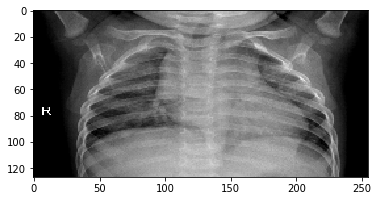

In [68]:
import matplotlib.pyplot as plt
plt.imshow(X[0])
plt.show()

### Can I use ML to predict what the label of the image: healthy vs. not healthy (Pnemonia)?

In [69]:
#making images b/w to run the fully connected
bw = []
for i in tqdm(data['X_ray_image_name']):
        bw.append(cv.resize(cv.imread(full_path+i),(min(imgx),min(imgy)))[:, :, 0])


100%|██████████| 5910/5910 [01:57<00:00, 50.33it/s]


## **Dense Network**

#### Make the train, test portion

In [70]:
XBW = np.array(bw)
y = data['Label']
X_trainBW,X_testBW,y_trainBW,y_testBW = train_test_split(XBW,y,
                                                         test_size=0.3,
                                                         random_state=12345)

In [71]:
print('Train:')
print(y_trainBW.value_counts(),'\n')
print('Test:')
print(y_testBW.value_counts())


Train:
1    3040
0    1097
Name: Label, dtype: int64 

Test:
1    1294
0     479
Name: Label, dtype: int64


In [72]:
print(len(X_train), min(imgx)*min(imgy))
X_trainBW = X_trainBW.reshape(len(X_trainBW), min(imgx)*min(imgy)).astype('float32')
X_testBW = X_testBW.reshape(len(X_testBW), min(imgx)*min(imgy)).astype('float32')
# we can try to noramlize the data so that we can use it in a dense network
X_trainBW /= np.amax(X_trainBW)
X_testBW /= np.amax(X_testBW)

4137 32385


In [73]:
X_trainBW.shape

(4137, 32385)

In [74]:
#note: maybe us keras.preprocessing.image.ImageDataGenerator to make a validate / test set..?

In [96]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.optimizers import SGD

The basic principle followed in building a convolutional neural network is to:<br> ‘keep the feature space wide and shallow in the initial stages of the network, and the make it narrower and deeper towards the end.’

In [76]:
model = Sequential()
model.add(Dense(2,input_shape=(32385,),activation='softmax'))
model.compile(optimizer=SGD(lr=0.1),
 loss='categorical_crossentropy',
 metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 64772     
Total params: 64,772
Trainable params: 64,772
Non-trainable params: 0
_________________________________________________________________


In [89]:
#changing to categorical so that we can look at the acc
y_testBW_binary = to_categorical(y_testBW)
y_trainBW_binary = to_categorical(y_trainBW)

model_history = model.fit(x=X_trainBW,y=y_trainBW_binary,
                          validation_data=(X_testBW,y_testBW_binary),
                          epochs = 10)

Train on 4137 samples, validate on 1773 samples
Epoch 1/10
4137/4137 [==============================] - 1s 151us/step - loss: 12.0551 - accuracy: 0.8941 - val_loss: 5.0011 - val_accuracy: 0.9284
Epoch 2/10
4137/4137 [==============================] - 1s 127us/step - loss: 13.2753 - accuracy: 0.8784 - val_loss: 109.8188 - val_accuracy: 0.7310
Epoch 3/10
4137/4137 [==============================] - 1s 137us/step - loss: 14.4533 - accuracy: 0.8871 - val_loss: 24.3985 - val_accuracy: 0.7704
Epoch 4/10
4137/4137 [==============================] - 0s 117us/step - loss: 13.0821 - accuracy: 0.8837 - val_loss: 8.6425 - val_accuracy: 0.8951
Epoch 5/10
4137/4137 [==============================] - 0s 117us/step - loss: 10.9931 - accuracy: 0.8939 - val_loss: 6.3302 - val_accuracy: 0.9188
Epoch 6/10
4137/4137 [==============================] - 0s 117us/step - loss: 10.6616 - accuracy: 0.9033 - val_loss: 14.6815 - val_accuracy: 0.8731
Epoch 7/10
4137/4137 [==============================] - 1s 130us/s

**notes on how to interpret output:**
1. val_loss starts increasing, val_acc starts decreasing(means model is cramming values not learning)

2. val_loss starts increasing, val_acc also increases.(could be case of overfitting or diverse probability values in cases softmax is used in output layer)

3. val_loss starts decreasing, val_acc starts increasing(Correct, means model build is learning and working fine)

https://stackoverflow.com/questions/51704808/what-is-the-difference-between-loss-accuracy-validation-loss-validation-accur
https://stackoverflow.com/questions/34518656/how-to-interpret-loss-and-accuracy-for-a-machine-learning-model

Train on 4137 samples, validate on 1773 samples<br>
**Epoch 1/5**<br>
loss: 12.0551 - accuracy: 0.8941 - val_loss: 5.0011 - val_accuracy: 0.9284<br>
**Epoch 2/5**<br>
loss: 13.2753 - accuracy: 0.8784 - val_loss: 109.8188 - val_accuracy: 0.7310 ... **cramming!** <br>
**Epoch 3/5**<br>
loss: 14.4533 - accuracy: 0.8871 - val_loss: 24.3985 - val_accuracy: 0.7704 ... **cramming?**<br>
**Epoch 4/5**<br>
loss: 13.0821 - accuracy: 0.8837 - val_loss: 8.6425 - val_accuracy: 0.8951 ... **cramming**<br>
**Epoch 5/5**<br>
loss: 10.9931 - accuracy: 0.8939 - val_loss: 6.3302 - val_accuracy: 0.9188 ... **cramming**<br>
....

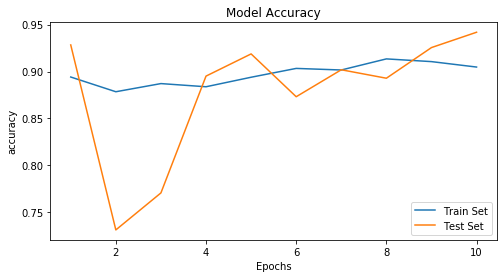

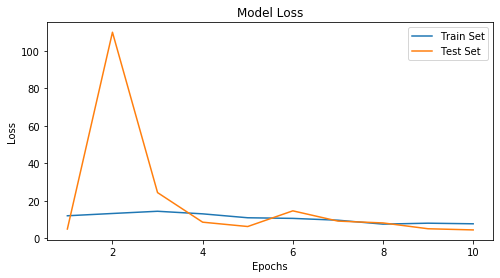

In [149]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs_range = range(1, 10 + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Model Accuracy')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

## Lets try a CNN 

**general rules to follow** 
1. use smaller filters in the beginning to collect as much local info as possible. Then gradually increase the filter width to represent more global info. The increase in filters increase depth. (general 3x3,5x5,7x7)
2. number of channels should be low to help with detecting low-level features. <br>
**by convention the number of channels either increase or stay the same as we move up**
3. use padding if you think the borders are important. My data is x-rays so not really, just dead space
4. Add lays till overfit (???) and then once we achieved a considerable accuracy in our validation set we can use regularization components like l1/l2 regularization, dropout, batch norm, data augmentation etc. to reduce over-fitting
5. When lost, try to refer back to networks that have good architectures: AlexNet, LeNet, VGG-16. Number of channels 32–64–128 or 32–32-64–64 or trend in filter sizes, Max-pooling parameters etc.

**also note:** <br>
 Convolution or Pooling layer we reduce the dimensions of the input image of dimensions N to (N-f+1)/s where where ‘f’ is the filter size and ‘s’ the stride length this will be very helpful to us during the process.

https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7

In [135]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [6]:
#so now were building a model.. simple model from datacamp. 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model2 = Sequential()
#add model layers
model2.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(min(imgy),min(imgx),3)))
model2.add(Conv2D(64, kernel_size=3, activation='relu'))
model2.add(Flatten())
model2.add(Dense(2, activation='softmax'))
#compile model using accuracy to measure model performance
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 125, 253, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 123, 251, 64)      18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1975872)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3951746   
Total params: 3,971,138
Trainable params: 3,971,138
Non-trainable params: 0
_________________________________________________________________


In [11]:
y = data['Label']
X = np.array(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.3,
                                                 random_state=12345)
y_test_binary = to_categorical(y_test)
y_train_binary = to_categorical(y_train)

model2.fit(x=X_train,y=y_train_binary,validation_data=(X_test,y_test_binary),epochs=5)

Train on 4137 samples, validate on 1773 samples
Epoch 1/5
4137/4137 [==============================] - 151s 37ms/step - loss: 248.9919 - accuracy: 0.8011 - val_loss: 0.4035 - val_accuracy: 0.8720
Epoch 2/5
4137/4137 [==============================] - 155s 38ms/step - loss: 0.2298 - accuracy: 0.9398 - val_loss: 0.3786 - val_accuracy: 0.8782
Epoch 3/5
4137/4137 [==============================] - 162s 39ms/step - loss: 0.0945 - accuracy: 0.9734 - val_loss: 0.4164 - val_accuracy: 0.8855
Epoch 4/5
4137/4137 [==============================] - 150s 36ms/step - loss: 0.0472 - accuracy: 0.9894 - val_loss: 0.4639 - val_accuracy: 0.8878
Epoch 5/5
4137/4137 [==============================] - 158s 38ms/step - loss: 0.0230 - accuracy: 0.9954 - val_loss: 0.5316 - val_accuracy: 0.8895


Train on 4137 samples, validate on 1773 samples
**Epoch 1/5**
loss: 248.9919 - accuracy: 0.8011 - val_loss: 0.4035 - val_accuracy: 0.8720 ... **learning**<br>
**Epoch 2/5**
loss: 0.2298 - accuracy: 0.9398 - val_loss: 0.3786 - val_accuracy: 0.8782 ... **learning**<br>
**Epoch 3/5**
loss: 0.0945 - accuracy: 0.9734 - val_loss: 0.4164 - val_accuracy: 0.8855 ... **overfitting?**<br>
**Epoch 4/5**
loss: 0.0472 - accuracy: 0.9894 - val_loss: 0.4639 - val_accuracy: 0.8878 ... **overfitting??**<br>
**Epoch 5/5**
loss: 0.0230 - accuracy: 0.9954 - val_loss: 0.5316 - val_accuracy: 0.8895 ... **overfitting???**<br>

### Lets try to optimize the hyper-parameters & stop overfitting

In [98]:
model_test = Sequential()
#add model layers
model_test.add(Conv2D(96, kernel_size=11, strides = 4,activation='relu', input_shape=(min(imgy),min(imgx),3)))
model_test.add(MaxPooling2D(2))
model_test.add(Conv2D(64, kernel_size=5, activation='relu'))
model_test.add(MaxPooling2D(2))
model_test.add(Flatten())
model_test.add(Dense(2, activation='softmax'))
#compile model using accuracy to measure model performance
model_test.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_test.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 62, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 31, 96)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 27, 64)        153664    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 13, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4160)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 8322      
Total params: 196,930
Trainable params: 196,930
Non-trainable params: 0
________________________________________________

In [99]:
model_test.fit(x=X_train,y=y_train_binary,validation_data=(X_test,y_test_binary),epochs=5)

Train on 4137 samples, validate on 1773 samples
Epoch 1/5
4137/4137 [==============================] - 23s 6ms/step - loss: 3.9182 - accuracy: 0.7960 - val_loss: 0.2142 - val_accuracy: 0.9143
Epoch 2/5
4137/4137 [==============================] - 21s 5ms/step - loss: 0.2272 - accuracy: 0.9079 - val_loss: 0.2093 - val_accuracy: 0.9227
Epoch 3/5
4137/4137 [==============================] - 21s 5ms/step - loss: 0.2474 - accuracy: 0.9142 - val_loss: 0.1862 - val_accuracy: 0.9284
Epoch 4/5
4137/4137 [==============================] - 22s 5ms/step - loss: 0.1828 - accuracy: 0.9328 - val_loss: 0.1803 - val_accuracy: 0.9312
Epoch 5/5
4137/4137 [==============================] - 22s 5ms/step - loss: 0.1709 - accuracy: 0.9352 - val_loss: 0.1781 - val_accuracy: 0.9210


## maybe i can create a validation set, and then I can save the test set for a real accuray score

In [106]:
X_train.shape
# min(imgy)

(4137, 127, 255, 3)

In [146]:
from keras.preprocessing.image import ImageDataGenerator
dataset = '/Volumes/noName/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset'
train_dir = r'{}/train'.format(dataset)
test_dir = r'{}/test'.format(dataset)

## Model Params
## Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).
image_size = 150
batch_size = 50
nb_classes = 2

train_datagen = ImageDataGenerator(rescale = 1./255,     # Convert all pixels to 0-1
                              width_shift_range = 0.1,   # The magnitude of the horizontal shift of the picture when the data is improved
                              height_shift_range = 0.1,  # The magnitude of the vertical shift of the picture when the data is boosted
                              shear_range = 0.2,         # Set the shear strength
                              horizontal_flip = True,    # Randomly select half of the picture to flip horizontally
                              fill_mode ='nearest')      #The points that exceed the boundary will be processed according to the method given by this parameter.Generally, there are some  
                                                         # ‘constant’，‘nearest’，‘reflect’或‘wrap。

test_datagen = ImageDataGenerator(rescale = 1./255)


In [147]:
print("traning set: ")
batch_size = 50

# Generate batches of tensor image data through real-time data augmentation. Data will be continuously cycled (by batch)

train_datagen = train_datagen.flow_from_directory(dataset,              # The path to the target directory. Each class should contain a subdirectory. 
                                               batch_size=batch_size,     # The size of the batch of data (default 32)
                                               class_mode='categorical')  # class_mode is one of categorical "," binary "," sparse "or None, which determines the array form of the returned tags. categorical returns 2D one-hot encoded tags.
print("testing set: ")

test_datagen = test_datagen.flow_from_directory(dataset,
                                                (min(imgy), min(imgx)),
                                                batch_size=batch_size,
                                                class_mode='categorical')


#Define step count

train_steps = train_datagen.samples//batch_size # "//" means integer division
test_steps = test_datagen.samples//batch_size

traning set: 
Found 5933 images belonging to 2 classes.
testing set: 
Found 5933 images belonging to 2 classes.


In [136]:
train_dir

'/Volumes/noName/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'